In [1]:
from brian2 import *
from brian2modelfitting import *
import pandas as pd

Neural network successfully converged after 296 epochs.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

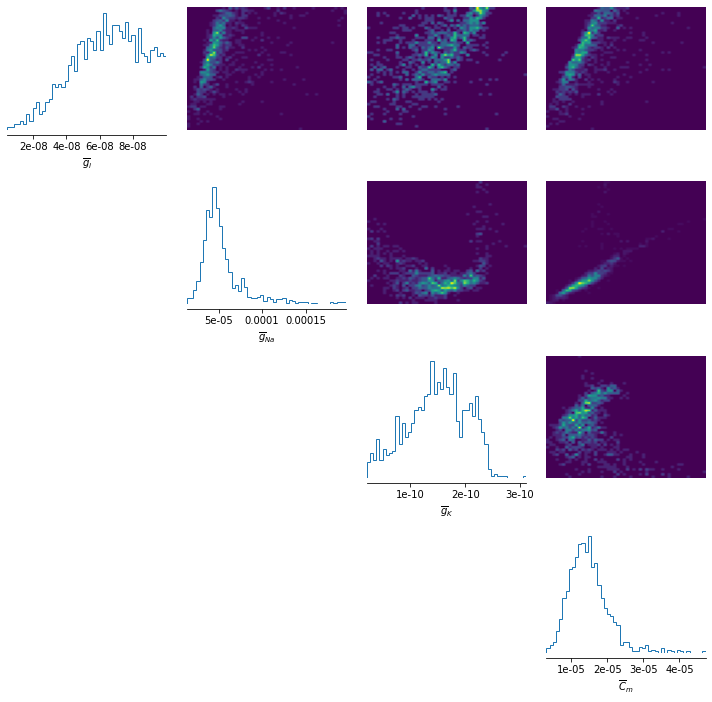

In [2]:
df_inp_traces = pd.read_csv('data/input_traces_hh.csv')
df_out_traces = pd.read_csv('data/output_traces_hh.csv')

inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[0, 1:]

out_traces = df_out_traces.to_numpy()
out_traces = out_traces[0, 1:]

area = 20000*umetre**2
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
dt = 0.01*ms
eqs='''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
    dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
        (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
        (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
        (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    g_na : siemens (constant)
    g_kd : siemens (constant)
    gl   : siemens (constant)
    Cm   : farad (constant)
'''
labels_params = [r'$\overline{g}_{l}$', r'$\overline{g}_{Na}$',
                 r'$\overline{g}_{K}$', r'$\overline{C}_{m}$']

inferencer = Inferencer(dt=dt, model=eqs,
                        input={'I': inp_traces*amp},
                        output={'v': out_traces*mV},
                        method='exponential_euler',
                        threshold='m > 0.5',
                        refractory='m > 0.5',
                        param_init={'v': 'VT'})

inferencer.generate(n_samples=5000,
                    gl=[1e-09*siemens, 1e-07*siemens],
                    g_na=[2e-06*siemens, 2e-04*siemens],
                    g_kd=[6e-07*siemens, 6e-05*siemens],
                    Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area])
inferencer.train()
samples = inferencer.sample(1000, viz=True,
                            labels=labels_params, figsize=(10, 10))